In [3]:
# pip install fasteda
# pip install cufflinks
# pip install plotly_express
# pip install scikit-learn
# pip install transformers -U -q
# pip install sentencepiece

In [48]:
import string
import re
import transformers
import numpy as np
import pandas as pd
import cufflinks as cf
import plotly_express
from fasteda import fast_eda
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Input
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [19]:
df = pd.read_csv("Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

In [20]:
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,ted,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
2,indic2012,This percentage is even greater than the percentage in India.,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called Upanishad.,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [21]:
df.tail()

,source,english_sentence,hindi_sentence
127602,indic2012,Examples of art deco construction can be found around Marine Drive and Oval Ground areas.,आर्ट डेको शैली के निर्माण मैरीन ड्राइव और ओवल मैदान के किनारे दिखाई देते हैं।
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।
127604,tides,"As for the other derivatives of sulphur , the country 's needs of iron , copper , sodium , etc . sulphates were limited , and the production achieved after the war was generally adequate .","जहां तक गंधक के अन्य उत्पादों का प्रश्न है , देश में लोहे , तांबे , सोडियम , सल्फेट आदि की आवश्यकता सीमित थी और युद्धोपरांत हुआ उत्पादन सामान्य रूप से पर्याप्त था ."
127605,tides,its complicated functioning is defined thus in a popular riddle :,Zरचना-प्रकिया को उसने एक पहेली में यों बांधा है .
127606,ted,"They've just won four government contracts to build off their 100 ambulances,","हाल ही में उन्हें सरकारी ठेका मिला है करीब सौ नई अम्बुलेन्स बनाने का,"


Missing Values

In [22]:
df.isna().sum()

source              0
english_sentence    2
hindi_sentence      0
dtype: int64

Dropping Missing Records

In [23]:
df = df.dropna()

In [24]:
df.isna().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

Description of Dataset

In [25]:
df.describe()

,source,english_sentence,hindi_sentence
count,127605,127605,127605
unique,3,124317,97662
top,tides,(Laughter),(हँसी)
freq,50000,555,212


Tokens and Char Count

In [26]:
cf.set_config_file(offline=True)
df["eng_char_count"] = df["english_sentence"].str.len()
df["hindi_char_count"] = df["hindi_sentence"].str.len()
df["hindi_tok_count"] = df["hindi_sentence"].str.split(" ").str.len()
df["eng_tok_count"] = df["english_sentence"].str.split(" ").str.len()

Most Common Words

In [28]:
from collections import Counter

tot_eng_sen = ""
for eng_sent in df["english_sentence"].tolist():
    tot_eng_sen += eng_sent + " "
    
Counter(tot_eng_sen.split(" ")).most_common(10)

[('the', 115944),
 ('of', 74298),
 ('and', 55015),
 (',', 52397),
 ('.', 50695),
 ('to', 47045),
 ('in', 41916),
 ('a', 34619),
 ('is', 29280),
 ('that', 17422)]

In [29]:
tot_hindi_sen = ""
for hin_sent in df["hindi_sentence"].tolist():
    tot_hindi_sen += hin_sent + " "
    
Counter(tot_hindi_sen.split(" ")).most_common(10)

[('के', 87750),
 ('में', 63389),
 ('है', 49672),
 ('की', 49069),
 ('.', 47650),
 ('और', 47371),
 ('से', 38061),
 (',', 33932),
 ('का', 33146),
 ('को', 31447)]

Fast EDA

DataFrame Head:


,source,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
0,ted,63,68,14,12
1,ted,42,50,11,9
2,indic2012,61,48,9,10


DataFrame Tail:


,source,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
127604,tides,188,164,34,36
127605,tides,65,49,10,11
127606,ted,77,69,14,12


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(127605, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127605 entries, 0 to 127606
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            127605 non-null  object
 1   eng_char_count    127605 non-null  int64 
 2   hindi_char_count  127605 non-null  int64 
 3   hindi_tok_count   127605 non-null  int64 
 4   eng_tok_count     127605 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 5.8+ MB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
eng_char_count,127605,89.326,65,82.01,1,38,65,119,2239,4.126609,43.441962
hindi_char_count,127605,88.125,64,84.531,1,37,64,116,2044,4.251456,39.706366
hindi_tok_count,127605,17.887,13,16.56,1,8,13,24,418,4.015886,37.967600
eng_tok_count,127605,16.092,12,14.454,1,7,12,21,398,3.706276,36.177745


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



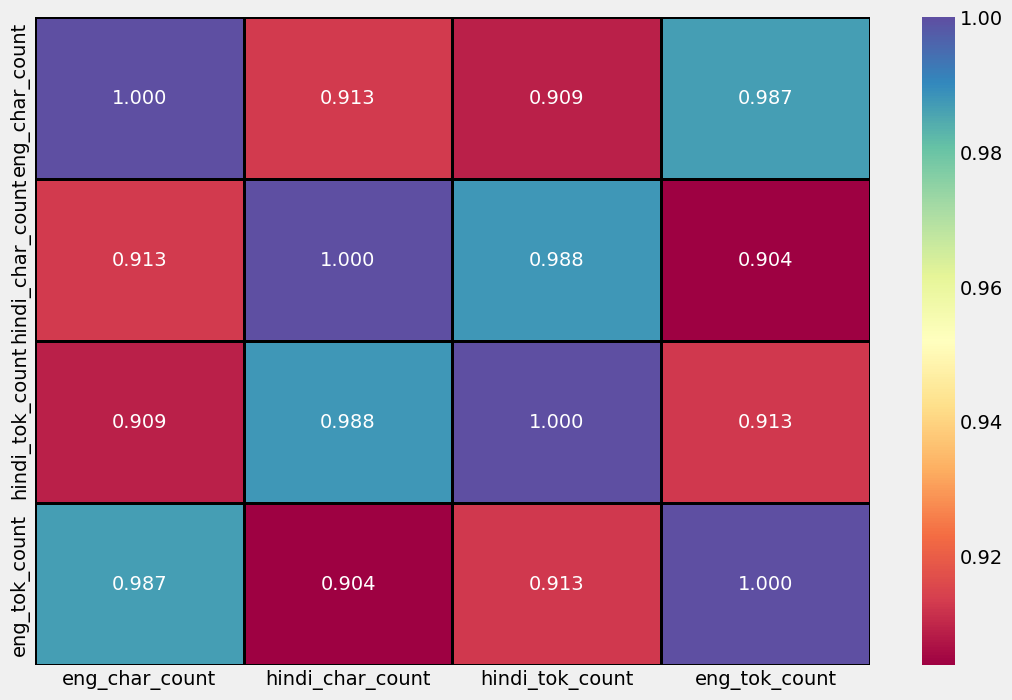

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



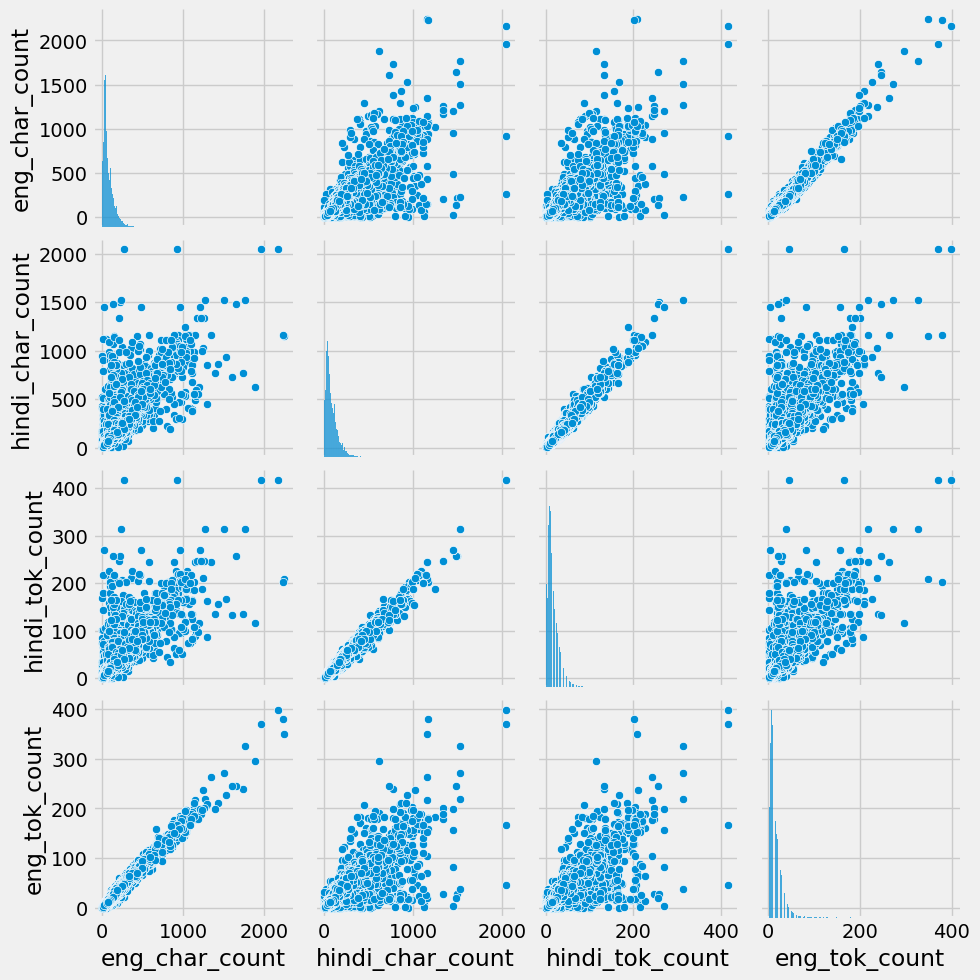

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



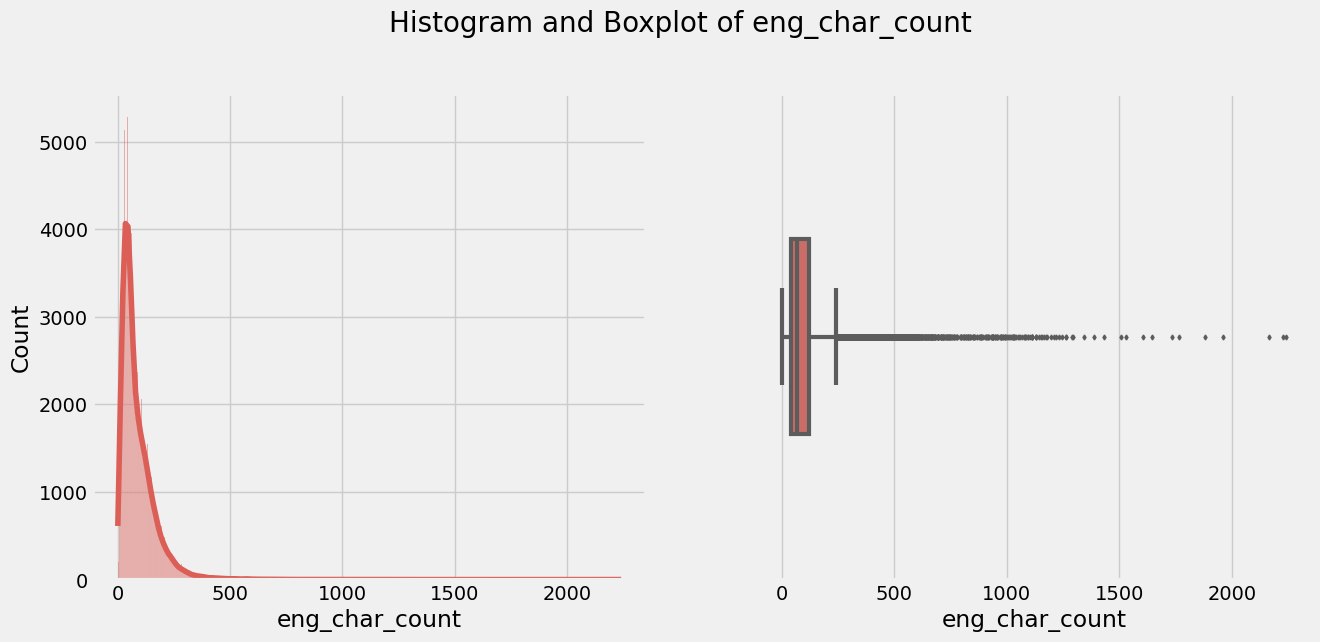

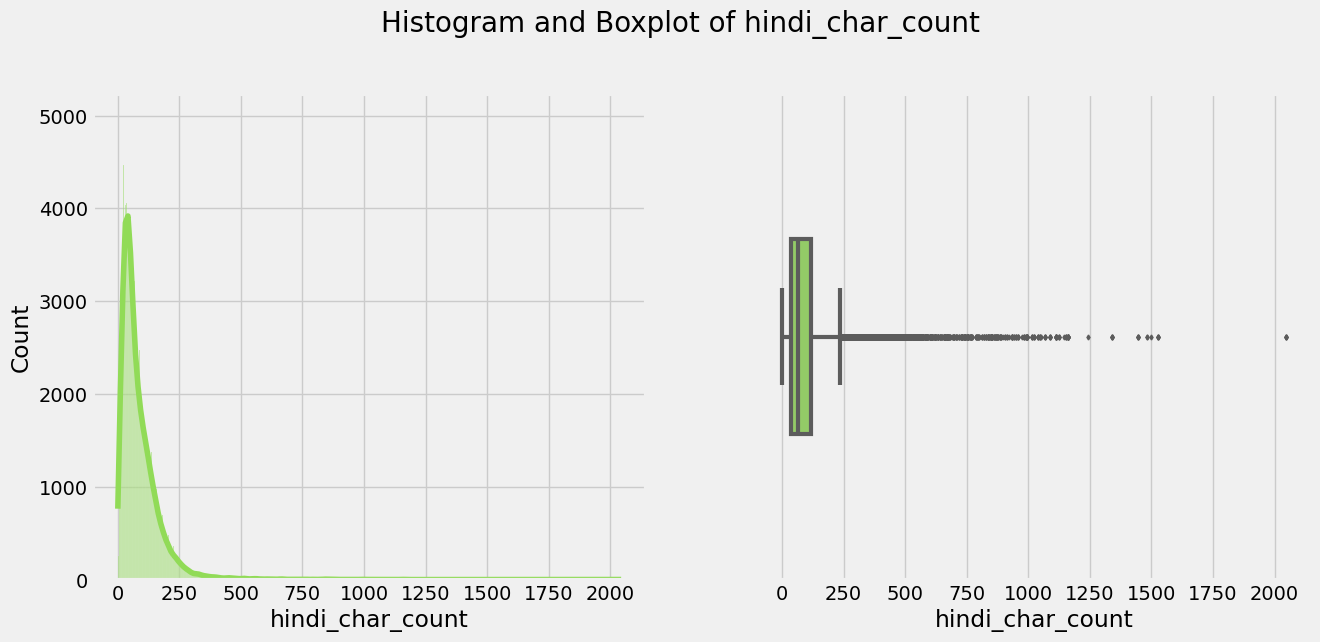

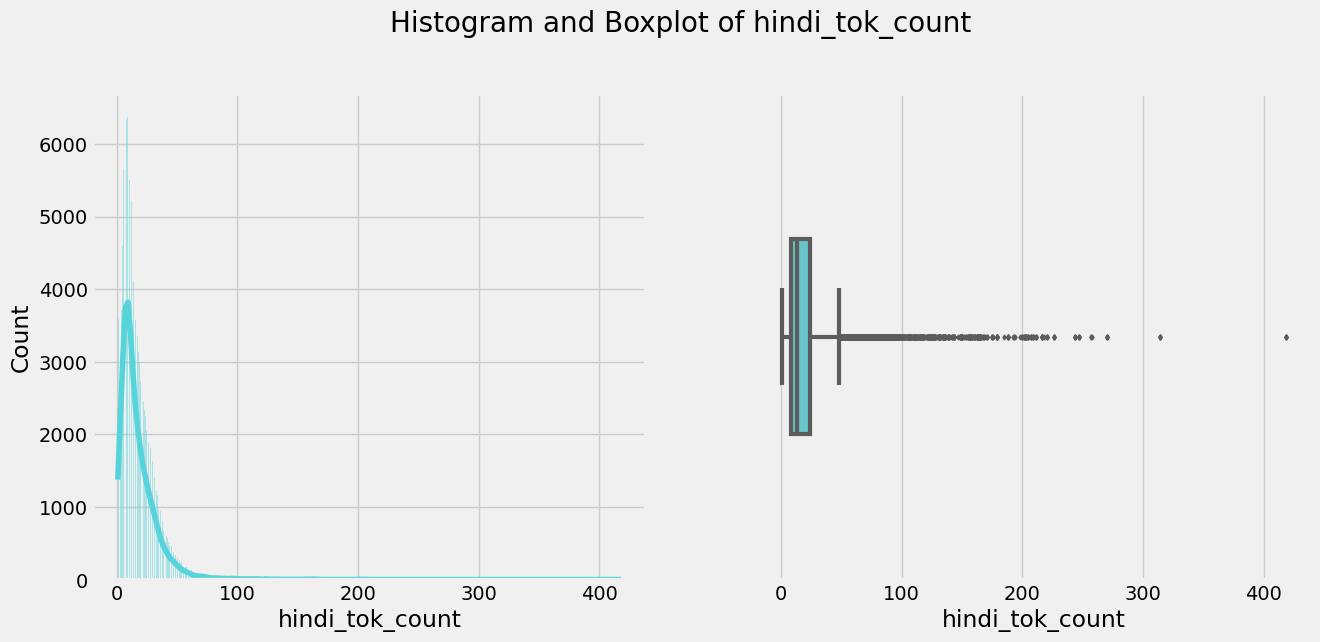

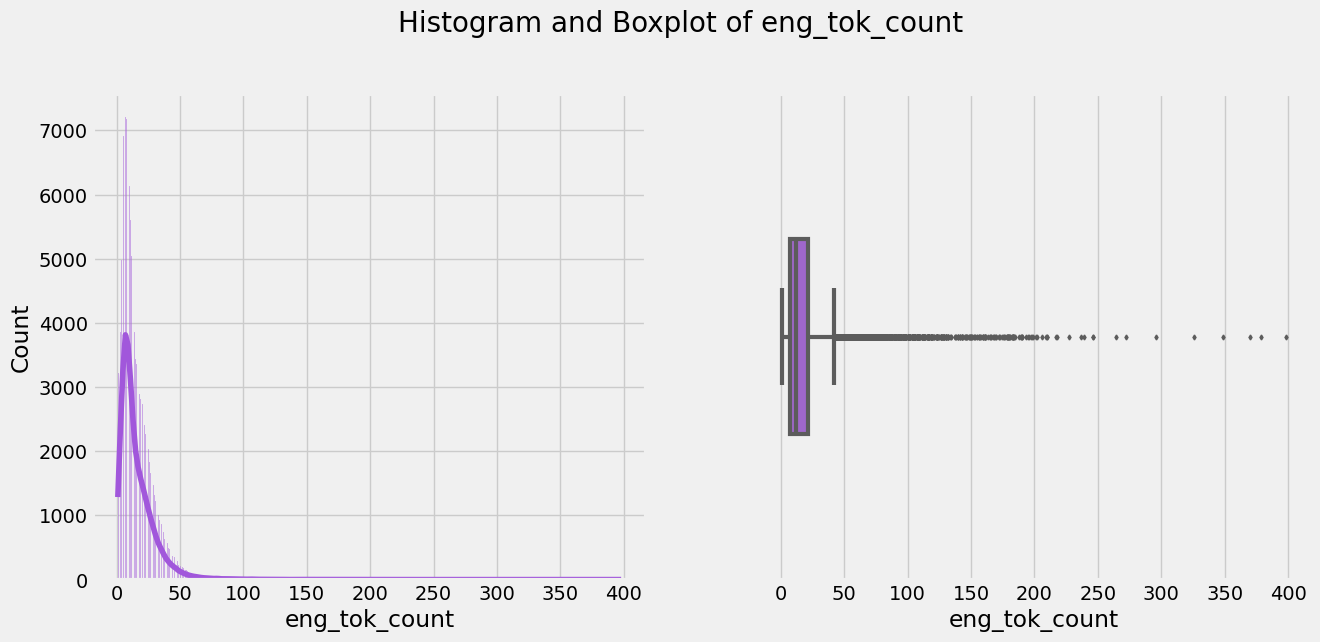

----------------------------------------------------------------------------------------------------
Countplot(s):



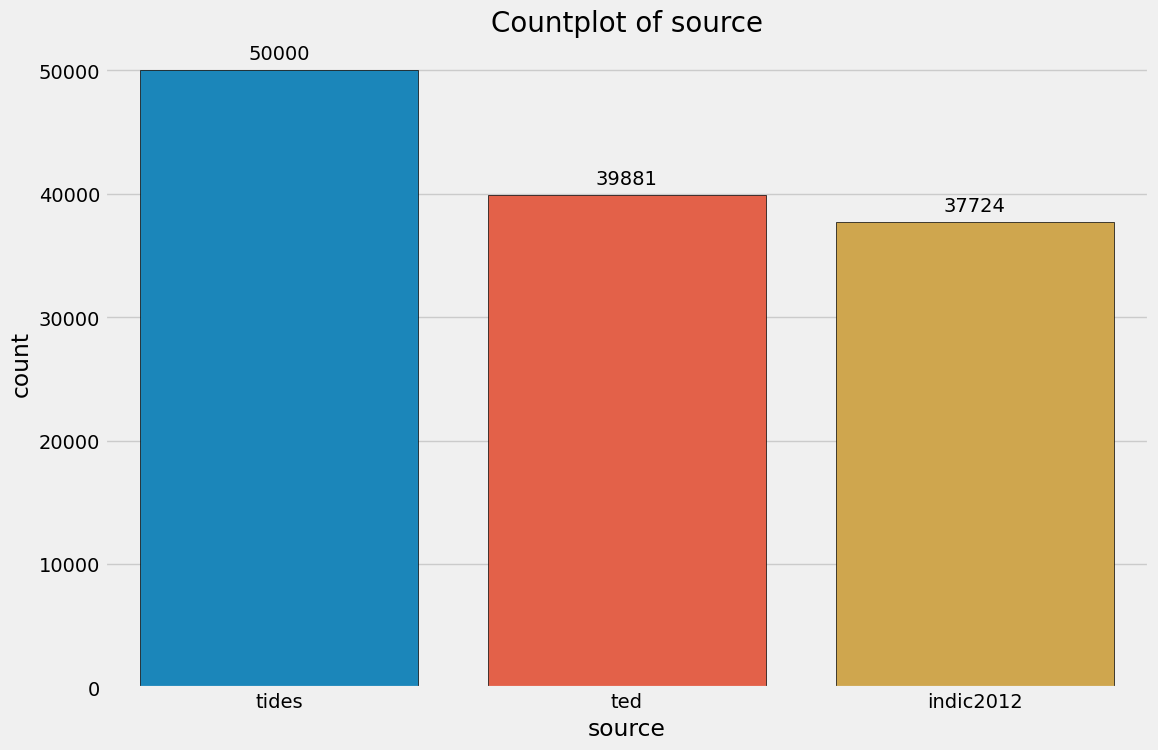

In [30]:
fast_eda(df[["source", "eng_char_count", "hindi_char_count", "hindi_tok_count", "eng_tok_count",]])

In [31]:
df

,source,english_sentence,hindi_sentence,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
0,ted,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है .",63,68,14,12
1,ted,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,",42,50,11,9
2,indic2012,This percentage is even greater than the percentage in India.,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,61,48,9,10
3,ted,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,64,46,11,12
4,indic2012,.The ending portion of these Vedas is called Upanishad.,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,55,43,8,9
...,...,...,...,...,...,...,...
127602,indic2012,Examples of art deco construction can be found around Marine Drive and Oval Ground areas.,आर्ट डेको शैली के निर्माण मैरीन ड्राइव और ओवल मैदान के किनारे दिखाई देते हैं।,89,77,15,15
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।,25,31,7,6
127604,tides,"As for the other derivatives of sulphur , the country 's needs of iron , copper , sodium , etc . sulphates were limited , and the production achieved after the war was generally adequate .","जहां तक गंधक के अन्य उत्पादों का प्रश्न है , देश में लोहे , तांबे , सोडियम , सल्फेट आदि की आवश्यकता सीमित थी और युद्धोपरांत हुआ उत्पादन सामान्य रूप से पर्याप्त था .",188,164,34,36
127605,tides,its complicated functioning is defined thus in a popular riddle :,Zरचना-प्रकिया को उसने एक पहेली में यों बांधा है .,65,49,10,11


Preprocessing

In [32]:
df=df[df['source']=='ted']

In [33]:
df.english_sentence = df.english_sentence.apply(lambda x: x.lower())
df.hindi_sentence = df.hindi_sentence.apply(lambda x: x.lower())

In [34]:
df.english_sentence = df.english_sentence.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' ', x))
df.hindi_sentence = df.hindi_sentence.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' ', x))

In [35]:
df['english_sentence']=df['english_sentence'].apply(lambda x: re.sub("'", '', x))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

In [36]:
exclude = set(string.punctuation)
df['english_sentence']=df['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [37]:
remove_digits = str.maketrans('', '', digits)
df['english_sentence']=df['english_sentence'].apply(lambda x: x.translate(remove_digits))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.translate(remove_digits))
df['hindi_sentence'] = df['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

df['english_sentence']=df['english_sentence'].apply(lambda x: x.strip())
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.strip())
df['english_sentence']=df['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [38]:
df.sample(10)

,source,english_sentence,hindi_sentence,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
23949,ted,cant do it you can buy it in russia,पर आप उसे रशिया में ख़रीद सकते हैं,38,35,8,9
87671,ted,when you can talk to me like a ” what,जब तुम” किसकी तरह बात कर सकते हो,39,38,9,10
70392,ted,for you per lot,एक गट्ठर ।,16,10,3,4
61801,ted,now when we come to the period after the second world war,अब जब हम द्वितीय विश्व युद्ध के बाद के समय को देखते हैं,58,55,13,12
98449,ted,malaria and tuberculosis combined,की कुल गिनती से अधिक है,34,24,6,4
69951,ted,when its obvious that its not working properly,जब ये साफ़ हो जाये कि ये ठीक से काम नहीं कर रहा,49,49,14,8
5942,ted,that im going to tell you about,जिसके बारे में मैं आपको बताने वाला हूँ,33,40,9,7
60545,ted,you can be compassionate occasionally,आप कभी कभी संवेदनशील करूणामय हो सकते हैं,38,43,8,5
95070,ted,to get to the nectar,पराग तक पहुँचने के लिए,21,24,6,5
109547,ted,and so heres what i found,तो मैंने ये पाया।,27,17,4,6


In [39]:
all_eng_words=set()
for eng in df['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in df['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [40]:
df['length_eng_sentence']=df['english_sentence'].apply(lambda x:len(x.split(" ")))
df['length_hin_sentence']=df['hindi_sentence'].apply(lambda x:len(x.split(" ")))

In [41]:
df.head()

,source,english_sentence,hindi_sentence,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count,length_eng_sentence,length_hin_sentence
0,ted,politicians do not have permission to do what needs to be done,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है,63,68,14,12,12,13
1,ted,id like to tell you about one such child,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,42,50,11,9,9,11
3,ted,what we really mean is that theyre bad at not paying attention,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,64,46,11,12,12,11
7,ted,and who are we to say even that they are wrong,और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं,48,48,13,11,11,13
13,ted,so there is some sort of justice,तो वहाँ न्याय है,32,16,4,7,7,4


In [42]:
print('length of english words: ', len(all_eng_words))
print('length of hindi words: ', len(all_hindi_words))

length of english words:  17292
length of hindi words:  22208


In [43]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(17292, 22208)

In [44]:
num_decoder_tokens += 1 #for zero padding

In [45]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [46]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [50]:
df = shuffle(df)
df.head(10)

,source,english_sentence,hindi_sentence,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count,length_eng_sentence,length_hin_sentence
87066,ted,who sailed to west africa in,जो मे पश्चिमी अफ़्रीका आया,34,32,6,7,6,5
57638,ted,that sometimes we develop,कभीकभी हम,25,10,2,4,4,2
61766,ted,is some foundational work some new technology,वो है कुछ आधारभूत काम कुछ नई तक़नीक़,46,37,8,7,7,8
127482,ted,in the case of the indus script,सिंधु लिपि के मामले में,32,24,5,7,7,5
30486,ted,so you see the style is different,जैसा कि आप देख सकते हैं इस काम की शैली अलग है,34,47,12,7,7,12
4751,ted,it was hard to believe,यह विश्वास करना कठिन था,22,23,5,5,5,5
42121,ted,and the whole spirit and attitude in those schools,और उन स्कूलों में उत्साह और रवैया,50,33,7,9,9,7
33262,ted,to talk to the imf and the world bank,imfअंतर्राष्ट्रिय मुद्रा कोष या वर्ल्ड बैंक से बात करने में,38,62,10,9,9,10
89580,ted,whether in this audience or people elsewhere in the world,या इन दर्शकों में या विश्व में अन्य कहीं के लोगों में,57,54,12,10,10,12
8157,ted,laughter,हंसी,10,6,1,1,1,1


In [51]:
# getting maximum sentence length of english sentences
length_list = []
for l in df.english_sentence:
    length_list.append(len(l.split(' ')))

max_input_length = np.max(length_list)
print('max_input_length: ', max_input_length)

max_input_length:  21


In [52]:
 #getting maximum sentence length of Hindi sentences
length_list = []
for l in df.hindi_sentence:
    length_list.append(len(l.split(' ')))

max_output_length = np.max(length_list)
print('max_output_length: ', max_output_length)

max_output_length:  30


In [53]:
df_=df[df['length_eng_sentence']<=25]
df_=df[df['length_hin_sentence']<=25]

In [54]:
print("maximum length of Hindi Sentence ",max(df['length_hin_sentence']))
print("maximum length of English Sentence ",max(df['length_eng_sentence']))

maximum length of Hindi Sentence  30
maximum length of English Sentence  21


In [55]:
x, y = df['english_sentence'], df['hindi_sentence']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5,random_state=42)
x_train.shape, x_test.shape

((19940,), (19941,))

In [56]:
x_train

108028                        which is keeping the outdoors out
108139                        as he drifted down the east river
66885                 and millions of oil dollars going missing
110854    audio ag most modern wind turbines consist of a large
24499                       and it becomes this dangerous cycle
                                  ...                          
98944                                                  applause
54660        because theyre seeing the world for the first time
97895         when my wife has divorced me my health is failing
43531               this meant the subjects loved their iphones
100561         “and what do you mean with western world” i said
Name: english_sentence, Length: 19940, dtype: object

In [57]:
y_train

108028               वह यह है कि हम बाहरी वातावरण को बहार ही रखते हैं
108139                            वो ईस्ट रिवर east river तक बहता गया
66885     और तेल से प्राप्त करोड़ों डॉलर के गायब हो जाने के बारे में।
110854       औडियो ए जी लगभग सभी आधुनिक पवन टर्बाइनो का बहुत बड़ा भाग
24499                               और यह एक खतरनाक चक्र बन जाता है ।
                                     ...                             
98944                                                         तालियाँ
54660                     क्योंकि वे इससे पहली बार मुखातिब हो रहे हैं
97895         मेरी पत्नी मुझे तलाक दे चुकी होगी मैं बीमार रहने लगूंगा
43531                           इस का मतलब उनका iphones से प्यार है ।
100561       “और पश्चिमी दुनिया से आपका क्या तात्पर्य है” मैंने पूछा।
Name: hindi_sentence, Length: 19940, dtype: object

In [59]:
x_train.values[9]

'and that they do care'

Implementation Using Encoder and Decoder

In [60]:
def generate_batch(X = x_train, y = y_train, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_input_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_output_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_output_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word]
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word]
                    if t>0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [61]:
latent_dim=300

In [62]:
from keras.utils import plot_model

In [63]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [64]:
# Setting up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [65]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [66]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            5187600   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 300)            6662700   ['input_2[0][0]']             
                                                                                              

In [67]:
train_samples = len(x_train)
val_samples = len(x_test)
batch_size = 128
epochs = 100

In [68]:
model.fit(generate_batch(x_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(x_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100
 15/155 [=>............................] - ETA: 6:17 - loss: 9.9967

KeyboardInterrupt: 

In [ ]:
model.save_weights('nmt_weights.h5')

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Getting the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(x_train, y_train, batch_size = 1)

In [ ]:
k=0
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', x_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])